# Simulating optimized cells in Arbor and cross-validation with Neuron

This notebook demonstrates how to run a simulation of a simple single compartmental cell with fixed/optimized parameters in Arbor. We follow the standard BluePyOpt flow of setting up an electrophysiological experiment and export the cell model to a mixed JSON/ACC-format. We then cross-validate voltage traces obtained with Arbor with those from a Neuron simulation.

In [1]:
# Choose subset of L5PC mechanisms to run (all regional mechs get re-mapped to soma)
mechanism_defs = dict(
    all=['pas'],
    somatic=['hh'])

extra_params = dict(
    v_init='global',
    # celsius='global',
    cm=['all'],
    Ra=['all'],
    g_pas=['all'],  # add 'pas' to mechs on all above
    e_pas=['all'],  # add 'pas' to mechs on all above
)

param_values_json = None

default_dt = 0.025

fine_dt = 0.001

voltage_residual_rel_l1_tolerance = 5e-2

run_spike_time_analysis = True

run_fine_dt = True

In [2]:
# Parameters
mechanism_defs = {"all": ["pas"], "axonal": ["Ca_HVA", "CaDynamics_E2", "Nap_Et2"]}
extra_params = {
    "v_init": "global",
    "celsius": "global",
    "g_pas": ["all"],
    "e_pas": ["all"],
    "cm": ["all"],
    "Ra": ["all"],
    "ena": ["axonal"],
}
param_values_json = "../../../BluePyOpt-utils/validation/all-regions/param_values.json"
default_dt = 0.025
run_spike_time_analysis = False
run_fine_dt = True
voltage_residual_rel_l1_tolerance = 0.05


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

First we need to compile the L5PC mechanisms and import the module that contains all the functionality to create electrical cell models

In [4]:
!nrnivmodl mechanisms
import bluepyopt as bpop
import bluepyopt.ephys as ephys

/home/lukasd/src/arbor/dev/BluePyOpt/examples/l5pc
Mod files: "mechanisms/CaDynamics_E2.mod" "mechanisms/Ca_HVA.mod" "mechanisms/Ca_LVAst.mod" "mechanisms/Ih.mod" "mechanisms/Im.mod" "mechanisms/K_Pst.mod" "mechanisms/K_Tst.mod" "mechanisms/Nap_Et2.mod" "mechanisms/NaTa_t.mod" "mechanisms/NaTs2_t.mod" "mechanisms/SK_E2.mod" "mechanisms/SKv3_1.mod"



COBJS=''
 -> Compiling mod_func.c
x86_64-linux-gnu-gcc -O2   -I.   -I/home/lukasd/src/arbor/dev/venv/lib/python3.8/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
x86_64-linux-gnu-g++ -O2 -DVERSION_INFO='8.0.2' -std=c++11 -shared -fPIC  -I /home/lukasd/src/arbor/dev/venv/lib/python3.8/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  ./mod_func.o ./CaDynamics_E2.o ./Ca_HVA.o ./Ca_LVAst.o ./Ih.o ./Im.o ./K_Pst.o ./K_Tst.o ./Nap_Et2.o ./NaTa_t.o ./NaTs2_t.o ./SK_E2.o ./SKv3_1.o  -L/home/lukasd/src/arbor/dev/venv/lib/python3.8/site-packages/neuron/.data/lib -lnrniv -Wl,-rpath,/home/lukasd/src/arbor/dev/venv/lib/python3.8/site-packages/neuron/.data/lib   


rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.so ./.libs/libnrnmech.so
Successfully created x86_64/special


In [5]:
import os
import sys
import tempfile
from dataclasses import dataclass
import typing
import warnings
import multiprocessing

import numpy
import pandas
import scipy.integrate
import scipy.interpolate

import arbor

from IPython.display import display

If you want to see a lot of information about the internals, 
the verbose level can be set to 'debug' by commenting out
the following lines

In [6]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

## Setting up the cell model

We use a single-compartimental cell model with the same morphology as in the `simplecell` example, but mechanisms from the `l5pc` model. They are instantiated with different options for axon replacement policy and (by default randomly sampled) mechanism parameter values.

In [7]:
# parameter randomization
import json
import random

# os.chdir('../../../BluePyOpt/examples/l5pc')
import l5pc_model

## Creating the protocols

A protocol consists of a set of stimuli and recordings. These responses will later be used to compare voltage traces from simulations between Arbor and Neuron for different parameter values and axon replacement configurations.

For the protocols, we apply stimuli centrally at the soma and probe the membrane voltage at a slightly displaced location. For this purpose, we introduce locations in Arbor, which are specified by a relative position `pos` on a `branch` of the morphology.

In [8]:
# Arbor location
class ArbLocation(ephys.locations.Location):
    def __init__(self, name, branch, pos, comment=''):
        super().__init__(_arb_label(name), comment)
        self.branch = branch
        self.pos = pos

    def instantiate(self):
        return _arb_unlabel(self.name), '(location %s %s)' % (self.branch, self.pos)


# Helper functions
def _arb_label(name):
    return '"%s"' % name


def _arb_unlabel(name):
    return name[1:-1]


# Make locations available to Arbor by instantiating them on the label dictionary 
def instantiate_locations(labels, locations):
    labels.append(
        arbor.label_dict(
            dict([loc.instantiate() for loc in locations.values()])))


# Define locations on branch 0 of the morphology (soma)
arb_locations = dict(
    stim_loc=ArbLocation(
        name='stim_loc',
        branch=0,
        pos=0.5
    ),
    probe_loc=ArbLocation(
        name='probe_loc',
        branch=0,
        pos=0.75
    )
)

In [9]:
nrn_locations = dict(
    stim_loc=ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5),
    probe_loc=ephys.locations.NrnSeclistCompLocation(
        name='probe',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.75)
)

We use a modified version of the L5PC protocols with shortened stimulus duration and reduced amplitudes.

In [10]:
# Protocol prots configuration
protocol_steps = []
for name, amplitude, duration in [('bAP', 0.19, 5), ('Step1', 0.0458, 50), ('Step3', 0.095, 50)]:
    protocol_steps.append(
        dict(name=name,
             total_duration=120,
             stimuli=[
                 dict(name='%s.iclamp' % name,
                      location='stim_loc',
                      amplitude=amplitude,
                      delay=40,
                      duration=duration)],
             recordings=[
                 dict(name='%s.soma.v' % name,
                      location='probe_loc')]))

The current stimuli, voltage and spike recordings are made available to Arbor by lazily instantiating them on decors/cell models.

In [11]:
# Current stimuli
def instantiate_stimuli(decor, stimuli, locations):
    for stim in stimuli:
        decor.place(locations[stim['location']].name,
                    arbor.iclamp(stim['delay'],
                                 stim['duration'],
                                 current=stim['amplitude']),
                    stim['name'])

# Spike detection with a voltage threshold of -10 mV
# (different from spike_time observables in eFEL that measure 'peak_time')
def instantiate_spike_recordings(decor, recordings, locations):
    for i, rec in enumerate(recordings):
        decor.place(locations[rec['location']].name,
                    arbor.spike_detector(-10),
                    'spike_detector' + '.%s' % i)

# Attach voltage probe sampling at 10 kHz (every 0.1 ms).
def instantiate_voltage_recordings(cell_model, recordings, locations):
    for i, rec in enumerate(recordings):
        # alternatively arbor.cable_probe_membrane_voltage
        cell_model.probe('voltage',
                         locations[rec['location']].name,
                         frequency=10)

The protocols for Neuron are defined analogous to the L5PC model.

In [12]:
sweep_protocols = []
for prot_def in protocol_steps:
    stims = []
    for stim in prot_def['stimuli']:
        stims.append(ephys.stimuli.NrnSquarePulse(step_amplitude=stim['amplitude'],
                                                  step_delay=stim['delay'],
                                                  step_duration=stim['duration'],
                                                  location=nrn_locations[stim['location']],
                                                  total_duration=prot_def['total_duration']))

    recs = []
    for rec in prot_def['recordings']:
        recs.append(ephys.recordings.CompRecording(
                    name=rec['name'],
                    location=nrn_locations[rec['location']],
                    variable='v'))

    protocol = ephys.protocols.SweepProtocol(prot_def['name'], stims, recs)
    sweep_protocols.append(protocol)

nrn_protocol = ephys.protocols.SequenceProtocol('multistep', protocols=sweep_protocols)

## Running a protocol on an Arbor cable cell

To run a protocol in Arbor, we need to export the cell model to a mixed JSON/ACC-format and assemble an Arbor cable cell on which we instantiate the locations, protocol stimuli and recordings. We use this cell to build a `single_cell_model` that sets up the constituents of an Arbor simulation and enables running a sweep protocol.

To run the protocols also with Neuron, we follow the standard flow by creating a simulator object.

In [13]:
class ArbSequenceProtocol(ephys.protocols.Protocol):
    '''Run multiple sweep protocol steps and extract voltage traces/detected spikes'''

    def __init__(self, name, protocols, locations):
        super().__init__(name)
        self.protocols = protocols
        self.locations = locations

    @staticmethod
    def run_sweep_protocol(prot_def, locations, cell, params, dt):
        '''Write cell model to ACC/JSON and run sweep protocol step'''
        # Export cell model to mixed JSON/ACC-format
        with tempfile.TemporaryDirectory() as acc_dir:
            ephys.create_acc.output_acc(acc_dir, cell, params)
            cell_json, morph, labels, decor = \
                ephys.create_acc.read_acc(
                    os.path.join(acc_dir, cell.name + '.json'))

        # Instantiate protocols on cable cell components
        instantiate_locations(labels, locations)
        instantiate_stimuli(decor, prot_def['stimuli'], locations)
        instantiate_spike_recordings(decor, prot_def['recordings'], locations)
        
        # Create cable cell
        cable_cell = arbor.cable_cell(morph, labels, decor)
        # can output and visualize the cable cell in the Arbor GUI using
        # arbor.write_component(cable_cell, '<filename>.acc')

        # Create single cell model
        arb_cell_model = arbor.single_cell_model(cable_cell)

        # Add catalogues with explicit qualifiers
        arb_cell_model.properties.catalogue = arbor.catalogue()
        arb_cell_model.properties.catalogue.extend(
            arbor.default_catalogue(), "default::")
        arb_cell_model.properties.catalogue.extend(
            arbor.bbp_catalogue(), "BBP::")
    
        # Instantiate remaining voltage recording
        instantiate_voltage_recordings(arb_cell_model, prot_def['recordings'], locations)

        # Run the simulation for the protocol step
        arb_cell_model.run(tfinal=prot_def['total_duration'], dt=dt)

        # Collect results
        arb_resp = dict()
        for i, rec in enumerate(prot_def['recordings']):
            arb_resp[rec['name']] = \
                dict(time=arb_cell_model.traces[i].time,
                     voltage=arb_cell_model.traces[i].value,
                     spikes=arb_cell_model.spikes)  # TODO: handle global callback

        return arb_resp


    def run(self, cell_model, params, dt):
        arb_resp = dict()
        for prot_def in self.protocols:
            arb_resp.update(self.run_sweep_protocol(
                prot_def, self.locations, cell_model, params, dt))
        return arb_resp


arb_protocol = ArbSequenceProtocol('multistep', protocol_steps, arb_locations)

## Cross-validation of Arbor and Neuron voltage traces

To validate Arbor's simulation output with that of Neuron, we run the protocols over a set of parameter values, either loaded from a JSON-file or randomly sampled from the parameter bounds (using `random.uniform(*bounds)`) and both with and without axon replacement.

First, we gather L5PC mechanisms and parameters according to `mechanism_defs` and `extra_params` in the top cell of this notebook.

In [14]:
mechanisms = l5pc_model.create_mechanisms(
    dict(all=mechanism_defs['all'],
         somatic=[mech for loc, mechs in mechanism_defs.items() 
                  if loc != 'all' for mech in mechs]))

l5pc_param_configs = l5pc_model.load_parameters()
l5pc_param_names = []
for p in l5pc_param_configs:
    if 'mech' in p and p['mech'] in mechanism_defs.get(p['sectionlist'], []):
        l5pc_param_names.append(p['param_name'] + '.' + p['sectionlist'])

param_configs = []
for p in l5pc_param_configs:
    if 'mech' not in p:
        if p['param_name'] in extra_params and (p['type'] == 'global' or \
            p['sectionlist'] in extra_params[p['param_name']]):
            if p['type'] != 'global' and p['sectionlist'] != 'all':
                p['sectionlist'] = 'somatic'  # remap to soma
            param_configs.append(p)

    elif p['mech'] in mechanism_defs.get(p['sectionlist'], []):
        p['sectionlist'] = 'somatic'  # remap to soma
        param_configs.append(p)

if 'somatic' in mechanism_defs and 'hh' in mechanism_defs['somatic']:
    for param_name, bounds in [('gnabar', (0.05, 0.125)),
                               ('gkbar', (0.01, 0.075))]:
        param_configs.append({
            "param_name": param_name + "_hh",
            "mech": "hh",
            "bounds": bounds,
            "dist_type": "uniform",
            "type": "range",
            "sectionlist": "somatic"
        })

parameters = l5pc_model.create_parameters(param_configs)

# Print the names of all parameters
[p.name for p in parameters]

['g_pas.all',
 'e_pas.all',
 'cm.all',
 'Ra.all',
 'v_init',
 'celsius',
 'ena.somatic',
 'gNap_Et2bar_Nap_Et2.somatic',
 'gCa_HVAbar_Ca_HVA.somatic',
 'gamma_CaDynamics_E2.somatic',
 'decay_CaDynamics_E2.somatic']

We either randomly sample or read the values of non-frozen parameters from a file.

In [15]:
if not hasattr(arbor, "prune_tag"):  # skip axon replacement if not yet supported
    replace_axon = [False]
else:
    replace_axon = [False, True]

non_frozen_parameters = [param for param in parameters if not param.frozen]
param_names = [param.name for param in non_frozen_parameters]

if param_values_json is not None:
    with open(param_values_json) as f:
        params = []
        for param_sample in json.load(f):
            ps = dict()
            for p_name, p_value in param_sample.items():
                if p_name in l5pc_param_names:
                    ps[p_name.split('.')[0] + '.somatic'] = p_value
            params.append(ps)
else:
    params = [{param.name: random.uniform(*param.bounds)
               for param in non_frozen_parameters}
               for i in range(10)]
params

[{'gNap_Et2bar_Nap_Et2.somatic': 2.5397905871703563,
  'gCa_HVAbar_Ca_HVA.somatic': 0.00041678299912923945,
  'gamma_CaDynamics_E2.somatic': 0.015596840653767825,
  'decay_CaDynamics_E2.somatic': 715.5905740778992},
 {'gNap_Et2bar_Nap_Et2.somatic': 1.7968290619889444,
  'gCa_HVAbar_Ca_HVA.somatic': 0.0007365761733392706,
  'gamma_CaDynamics_E2.somatic': 0.01313306786527963,
  'decay_CaDynamics_E2.somatic': 624.2353268976092},
 {'gNap_Et2bar_Nap_Et2.somatic': 1.3609222271757924,
  'gCa_HVAbar_Ca_HVA.somatic': 4.319899979463693e-05,
  'gamma_CaDynamics_E2.somatic': 0.028080610838737318,
  'decay_CaDynamics_E2.somatic': 669.6397300091332},
 {'gNap_Et2bar_Nap_Et2.somatic': 2.863216846063319,
  'gCa_HVAbar_Ca_HVA.somatic': 0.00031502106477353676,
  'gamma_CaDynamics_E2.somatic': 0.0017571167300321929,
  'decay_CaDynamics_E2.somatic': 518.3682190492215},
 {'gNap_Et2bar_Nap_Et2.somatic': 1.5949727761082602,
  'gCa_HVAbar_Ca_HVA.somatic': 0.0007817020918297868,
  'gamma_CaDynamics_E2.somatic':

 We use a factory to create cell models with different configurations. This enables us to run both Arbor and Neuron simulations for the defined sequence protocols and each combination of axon replacement and parameter values...

In [16]:
@dataclass
class CellModelFactory:
    mechanisms: typing.List[ephys.mechanisms.NrnMODMechanism]
    parameters: typing.List[ephys.parameters.NrnParameter]

    def create_cell_model(self, do_replace_axon):

        morphology = ephys.morphologies.NrnFileMorphology(
            '../simplecell/simple.swc', do_replace_axon=do_replace_axon)

        return ephys.models.CellModel(
            'simple_cell',
            morph=morphology,
            mechs=self.mechanisms,
            params=self.parameters)

@dataclass
class SimulationRunner:
    cell_factory: CellModelFactory
    arb_protocol: ArbSequenceProtocol
    nrn_protocol: ephys.protocols.SequenceProtocol

    def run_all(self, replace_axon_policies, param_list, dt=0.025):
        arb_resp = dict()
        nrn_resp = dict()

        nrn_sim = ephys.simulators.NrnSimulator(dt=dt)

        for do_replace_axon in replace_axon_policies:
            for param_i in range(len(param_list)):

                cell_model = self.cell_factory.create_cell_model(do_replace_axon=do_replace_axon)

                # calculate morphology with axon-replacement in Neuron
                cell_model.instantiate_morphology(nrn_sim)

                key = (do_replace_axon, param_i)
                arb_resp[key] = self.arb_protocol.run(cell_model, param_list[param_i], dt=dt)

                # need to destroy instantiated cell model first to avoid Hoc serialization error
                cell_model.destroy(sim=nrn_sim)

                nrn_resp[key] = self.nrn_protocol.run(cell_model, param_list[param_i], nrn_sim)
        return arb_resp, nrn_resp


cell_factory = CellModelFactory(mechanisms, parameters)
simulation_runner = SimulationRunner(cell_factory, arb_protocol, nrn_protocol)
arb_responses, nrn_responses = simulation_runner.run_all(replace_axon, params, default_dt)

...and to plot the responses for visual validation.

In [17]:
def plot_response_comparison(arb_resp, nrn_resp, title):
    num_protocols = len(protocol_steps)
    num_recs = max([len(step['recordings']) for step in protocol_steps])
    assert num_recs == 1  # add j as a second index with multiple recordings
    fig, ax = plt.subplots(num_protocols, num_recs, figsize=(12,7))
    for i, step in enumerate(protocol_steps):
        for j, rec in enumerate(step['recordings']):
            rec_name = rec['name']
            ax[i].plot(nrn_resp[rec_name]['time'], nrn_resp[rec_name]['voltage'], label='Neuron ' + rec_name)
            ax[i].plot(arb_resp[rec_name]['time'], arb_resp[rec_name]['voltage'], label='Arbor ' + rec_name)
            ax[i].set_title(title)
            ax[i].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

To analyze the responses, we compare the difference of voltage traces between Arbor and Neuron in the L1-norm. 

In [18]:

def voltage_trace_residual_l1_norm(int_resp, ref_resp):
    int_resp_func = scipy.interpolate.interp1d(int_resp['time'], int_resp['voltage'], kind='cubic')
    ref_resp_func = scipy.interpolate.interp1d(ref_resp['time'], ref_resp['voltage'], kind='cubic')
    abs_diff = lambda t: abs(int_resp_func(t)-ref_resp_func(t))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=scipy.integrate.IntegrationWarning)
        return scipy.integrate.quad(abs_diff, ref_resp['time'][0], ref_resp['time'][-1], limit=400)


def voltage_trace_residual_l1_norm_sweep_protocol(args):
    arb_resp = args['arb_resp']
    nrn_resp = args['nrn_resp']

    residual_l1_norm, residual_error = voltage_trace_residual_l1_norm(
        nrn_resp, arb_resp)

    nrn_to_min_l1_norm, nrn_to_min_error = \
        voltage_trace_residual_l1_norm(
            nrn_resp,
            dict(time=nrn_resp['time'].values,
                 voltage=numpy.full(nrn_resp['voltage'].shape,
                                    numpy.min(nrn_resp['voltage']))))
    return dict(
        residual_rel_l1_norm=residual_l1_norm/nrn_to_min_l1_norm,
        residual_rel_l1_error=residual_error/residual_l1_norm + \
                            nrn_to_min_error/nrn_to_min_l1_norm
    )


def analyze_voltage_traces_l1(arb_resp, nrn_resp):
    indices = [(key,step) for key in arb_resp for step in arb_resp[key]]

    # test_l5pc: insert if True:
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        l1_task_results = pool.map(voltage_trace_residual_l1_norm_sweep_protocol,
                                   [dict(arb_resp=arb_resp[key][step],
                                         nrn_resp=nrn_resp[key][step])
                                    for key, step in indices])

    l1_results = []
    for l1_task_result, (key, step) in zip(l1_task_results, indices):
            l1_results.append(
                dict(replace_axon=key[0],
                     param_i=key[1],
                     **params[key[1]],
                     protocol=step,
                     **l1_task_result))

    return pandas.DataFrame(l1_results)


l1_results = analyze_voltage_traces_l1(arb_responses, nrn_responses)
pandas.options.display.float_format = '{:,.3g}'.format
l1_results.sort_values(by='residual_rel_l1_norm', ascending=False).head(5)

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
12,False,4,1.59,0.000782,0.00283,697,bAP.soma.v,0.000227,1.88e-08
14,False,4,1.59,0.000782,0.00283,697,Step3.soma.v,0.000226,5.48e-08
13,False,4,1.59,0.000782,0.00283,697,Step1.soma.v,0.000226,1.16e-08
4,False,1,1.8,0.000737,0.0131,624,Step1.soma.v,0.000212,1.53e-08
3,False,1,1.8,0.000737,0.0131,624,bAP.soma.v,0.000211,9.41e-09


In [19]:
def print_voltage_trace_l1_results(config_str, l1_results):
    voltage_residual_rel_l1_error_tolerance = 1e-2 * voltage_residual_rel_l1_tolerance

    mean_rel_l1_norm = l1_results['residual_rel_l1_norm'].mean()
    mean_rel_l1_error = l1_results['residual_rel_l1_error'].mean()
    # max_l1_norm_record = l1_results.loc[l1_results['residual_rel_l1_norm'].idxmax()]

    message = '{}: test_l5pc %s! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are {:,.3g} ({:,.3g}), {:,.3g} ({:,.3g}).'.format(
        config_str, mean_rel_l1_norm, voltage_residual_rel_l1_tolerance, mean_rel_l1_error, voltage_residual_rel_l1_error_tolerance)
    if mean_rel_l1_norm < voltage_residual_rel_l1_tolerance and mean_rel_l1_error < voltage_residual_rel_l1_error_tolerance:
        print(message % 'OK')
    else:
        print(message % 'ERROR')


print_voltage_trace_l1_results('Default dt ({:,.3g})'.format(default_dt), l1_results)

Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00015 (0.05), 1.86e-08 (0.0005).


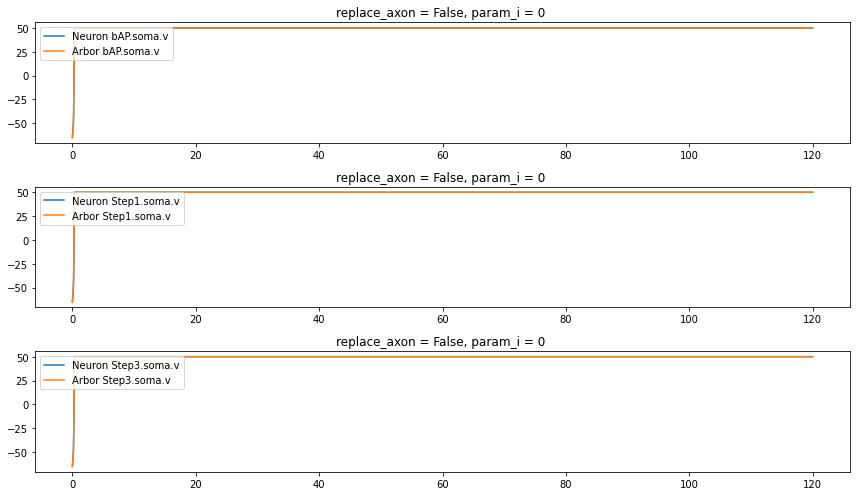

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
0,False,0,2.54,0.000417,0.0156,716,bAP.soma.v,0.000177,9.13e-09
1,False,0,2.54,0.000417,0.0156,716,Step1.soma.v,0.000178,1.42e-08
2,False,0,2.54,0.000417,0.0156,716,Step3.soma.v,0.000175,1.24e-08


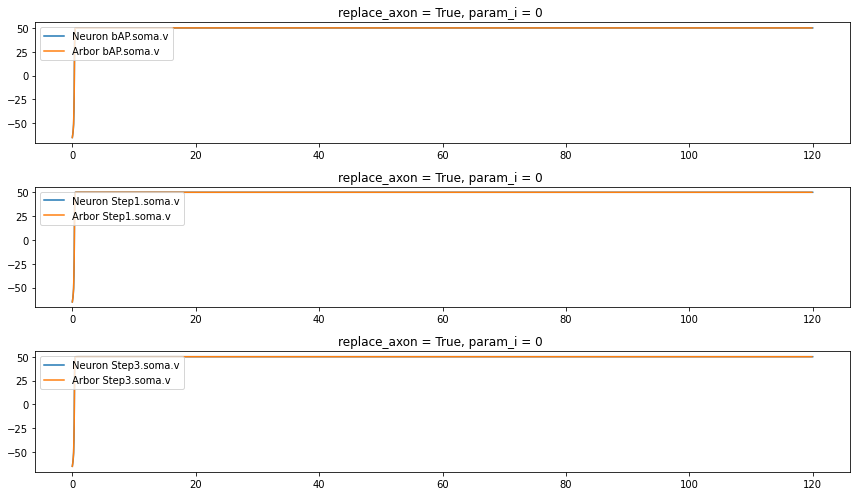

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
15,True,0,2.54,0.000417,0.0156,716,bAP.soma.v,9.88e-05,2.26e-08
16,True,0,2.54,0.000417,0.0156,716,Step1.soma.v,9.57e-05,3.81e-09
17,True,0,2.54,0.000417,0.0156,716,Step3.soma.v,9.91e-05,1.83e-08


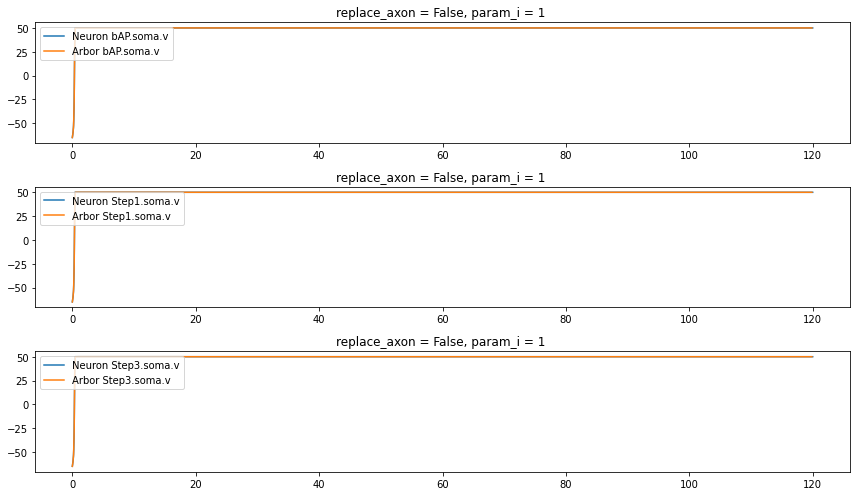

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
3,False,1,1.8,0.000737,0.0131,624,bAP.soma.v,0.000211,9.41e-09
4,False,1,1.8,0.000737,0.0131,624,Step1.soma.v,0.000212,1.53e-08
5,False,1,1.8,0.000737,0.0131,624,Step3.soma.v,0.000208,7.03e-09


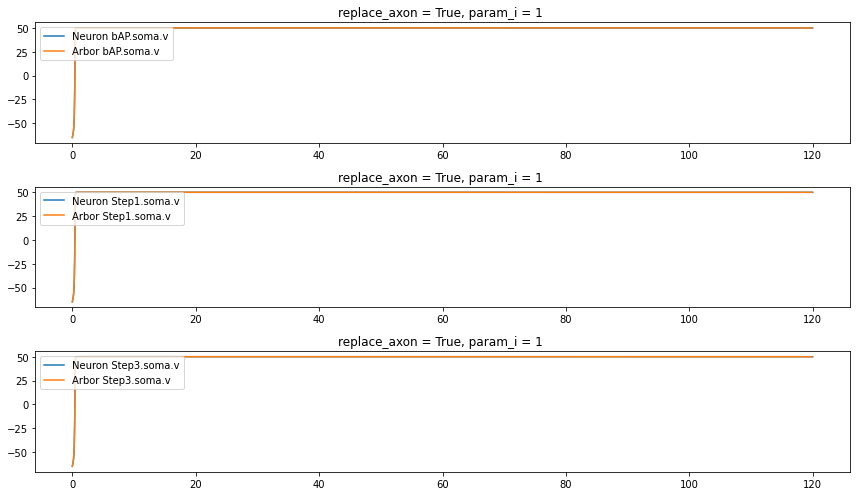

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
18,True,1,1.8,0.000737,0.0131,624,bAP.soma.v,0.000162,1.63e-08
19,True,1,1.8,0.000737,0.0131,624,Step1.soma.v,0.000162,8.46e-09
20,True,1,1.8,0.000737,0.0131,624,Step3.soma.v,0.000166,1.08e-08


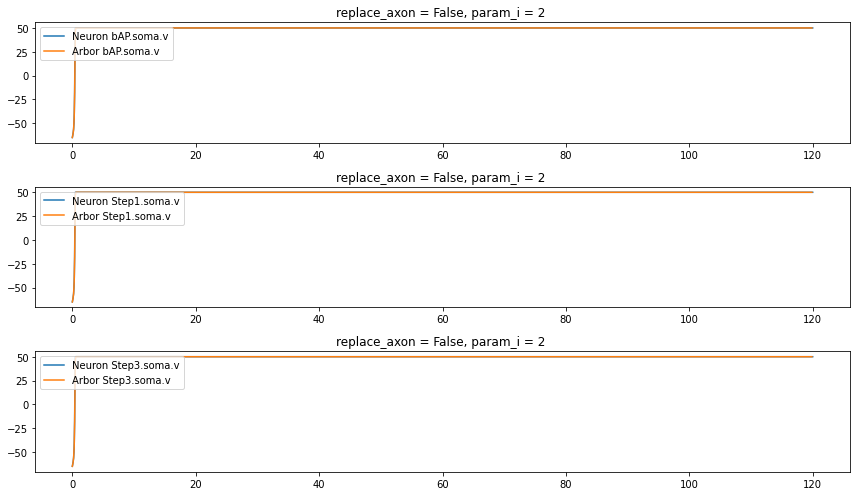

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
6,False,2,1.36,4.32e-05,0.0281,670,bAP.soma.v,0.00013,1.69e-08
7,False,2,1.36,4.32e-05,0.0281,670,Step1.soma.v,0.000128,2.04e-08
8,False,2,1.36,4.32e-05,0.0281,670,Step3.soma.v,0.000124,2.09e-08


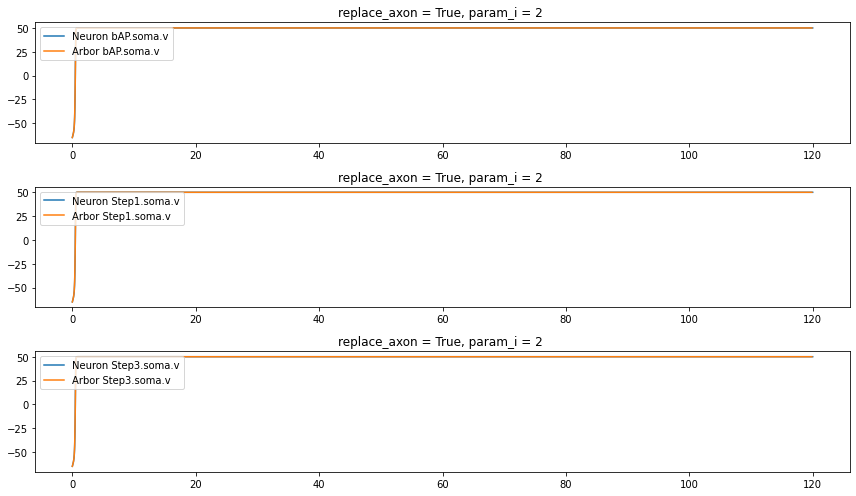

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
21,True,2,1.36,4.32e-05,0.0281,670,bAP.soma.v,9.6e-05,7.15e-08
22,True,2,1.36,4.32e-05,0.0281,670,Step1.soma.v,0.000102,1.52e-08
23,True,2,1.36,4.32e-05,0.0281,670,Step3.soma.v,9.56e-05,1.86e-08


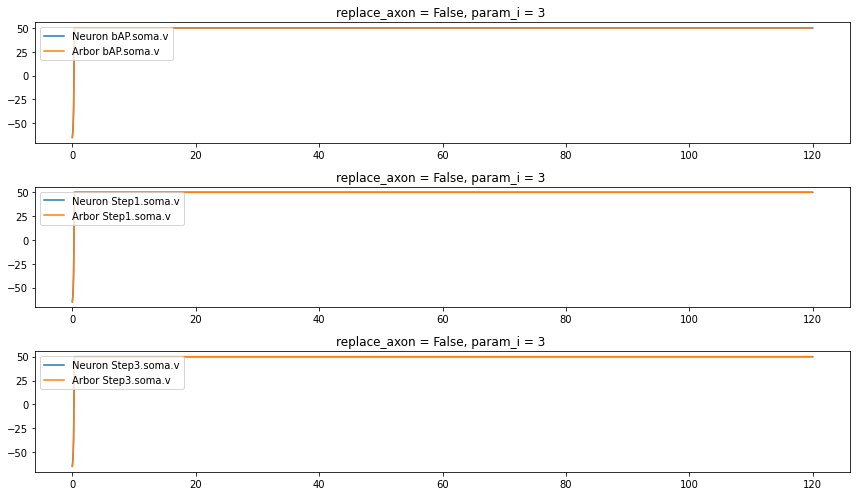

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
9,False,3,2.86,0.000315,0.00176,518,bAP.soma.v,0.000119,2.19e-08
10,False,3,2.86,0.000315,0.00176,518,Step1.soma.v,0.000128,2.18e-08
11,False,3,2.86,0.000315,0.00176,518,Step3.soma.v,0.000132,1.77e-08


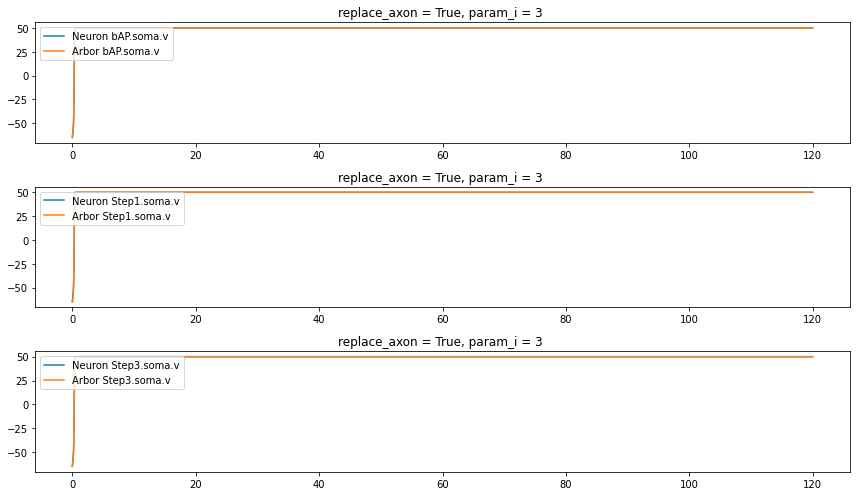

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
24,True,3,2.86,0.000315,0.00176,518,bAP.soma.v,0.000117,2.24e-08
25,True,3,2.86,0.000315,0.00176,518,Step1.soma.v,0.000119,1.54e-08
26,True,3,2.86,0.000315,0.00176,518,Step3.soma.v,0.000109,9.33e-09


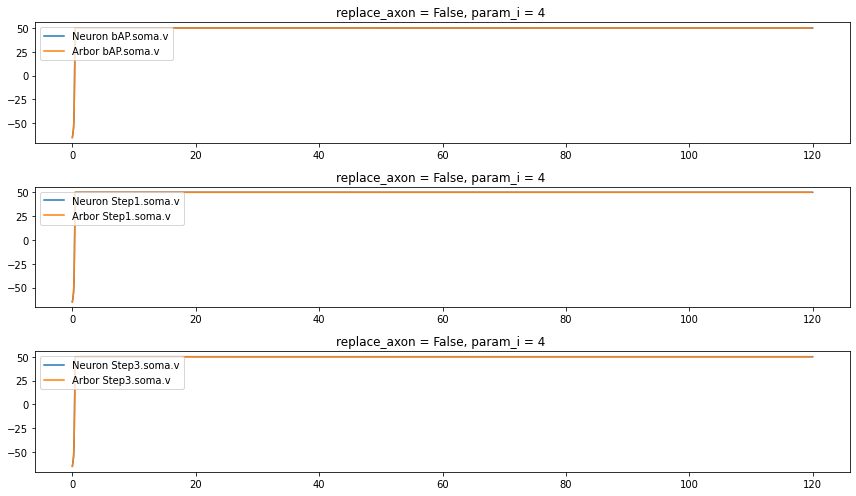

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
12,False,4,1.59,0.000782,0.00283,697,bAP.soma.v,0.000227,1.88e-08
13,False,4,1.59,0.000782,0.00283,697,Step1.soma.v,0.000226,1.16e-08
14,False,4,1.59,0.000782,0.00283,697,Step3.soma.v,0.000226,5.48e-08


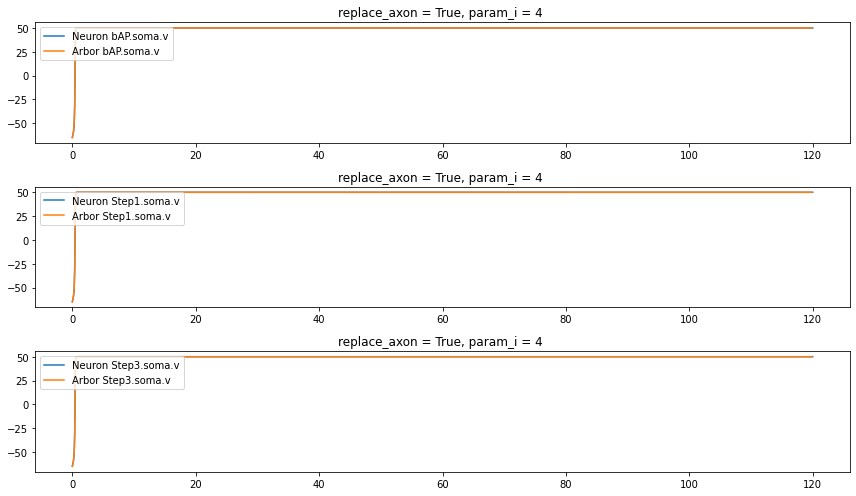

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
27,True,4,1.59,0.000782,0.00283,697,bAP.soma.v,0.000161,2.42e-08
28,True,4,1.59,0.000782,0.00283,697,Step1.soma.v,0.00016,1.35e-08
29,True,4,1.59,0.000782,0.00283,697,Step3.soma.v,0.00016,1.62e-08


In [20]:
def compare_responses(arb_resp, nrn_resp, l1_results, *key):
    if key in arb_resp:
        plot_response_comparison(arb_resp[key], nrn_resp[key], 'replace_axon = %s, param_i = %s ' % (key[0], key[1]))
        display(l1_results[(l1_results['replace_axon'] == key[0]) & (l1_results['param_i'] == key[1])])


for param_i in range(len(params)):  # test_l5pc: skip
    for do_replace_axon in replace_axon:  # test_l5pc: skip
        compare_responses(arb_responses, nrn_responses, l1_results, do_replace_axon, param_i)  # test_l5pc: skip

The voltage traces look mostly similar between Arbor and Neuron. Under certain conditions, we can perform spike time analysis to understand this quantitatively. 

### Spike time cross-validation

To compare Arbor and Neuron voltage traces further, we analyze the spike counts and times with the eFEL library and Arbor's built-in spike detector. Note that while eFEL measures the `peak_time`, Arbor's spike detector as configured above will measure the time when the voltage passes a threshold of -10 mV.

In [21]:
if run_spike_time_analysis:

    efel_features = ['Spikecount',
                    'time_to_first_spike',
                    'time_to_second_spike',
                    'time_to_last_spike']


    # Extract spike observables from protocol simulation responses
    def get_spike_data(protocols, do_replace_axon, param_values,
                       arb_resp, nrn_resp):
        spike_res = []

        for step in protocols:
            recording_name = step['recordings'][0]['name'] # use only first recording
            stim_start = min([stim['delay'] for stim in step['stimuli']])
            stim_end = max([stim['delay'] + stim['duration'] for stim in step['stimuli']])

            for efel_feature_name in efel_features:
                # Calculate spike observables with eFEL
                feature_name = '%s.%s' % (step['name'], efel_feature_name)
                feature = ephys.efeatures.eFELFeature(
                            feature_name,
                            efel_feature_name=efel_feature_name,
                            recording_names={'': recording_name},
                            stim_start=stim_start,
                            stim_end=stim_end)

                # Calculate spike observables with Arbor
                try:
                    if efel_feature_name == 'Spikecount':
                        arbor_int = len(arb_resp[recording_name]['spikes'])
                    elif efel_feature_name == 'time_to_first_spike':
                        arbor_int = arb_resp[recording_name]['spikes'][0]-stim_start
                    elif efel_feature_name == 'time_to_second_spike':
                        arbor_int = arb_resp[recording_name]['spikes'][1]-stim_start
                    elif efel_feature_name == 'time_to_last_spike':
                        arbor_int = arb_resp[recording_name]['spikes'][-1]-stim_start
                except Exception:
                    arbor_int = numpy.nan

                spike_res.append(dict(
                    replace_axon=do_replace_axon,
                    protocol=step['name'],
                    **param_values,
                    efel=efel_feature_name,
                    Neuron=feature.calculate_feature(nrn_resp),
                    Arbor=feature.calculate_feature(arb_resp),
                    Arbor_int=arbor_int))
        return spike_res


    # Compare spike observables between Arbor and Neuron
    def analyze_spikes(spike_res):
        spike_res_df = pandas.DataFrame(spike_res)
        spike_res_df.set_index(
            ['replace_axon', 'protocol',
             *param_names, 'efel'], inplace=True)
        spike_res_df.dropna(how='all', inplace=True)  # drop all-NaN rows

        # Arbor to Neuron cross-validation with eFEL
        spike_res_df['abs_diff Arbor to Neuron'] = \
            spike_res_df.apply(
                lambda r: abs(r['Arbor']-r['Neuron']), axis=1)
        spike_res_df['rel_abs_diff Arbor to Neuron [%]'] = \
            spike_res_df.apply(
                lambda r: 100.*abs(r['Arbor']-r['Neuron'])/r['Neuron']
                          if r['Neuron'] != 0 else numpy.nan, axis=1)

        # Cross-validation of eFEL's spike detection with Arbor's
        spike_res_df['abs_diff eFEL to Arbor-internal'] = \
            spike_res_df.apply(
                lambda r: abs(r['Arbor']-r['Arbor_int']), axis=1)
        spike_res_df['rel_abs_diff eFEL to Arbor-internal [%]'] = \
            spike_res_df.apply(
                lambda r: 100.*abs(r['Arbor']-r['Arbor_int'])/r['Arbor_int']
                          if r['Arbor_int'] != 0 else numpy.nan, axis=1)
        return spike_res_df


    # Aggregate all simulations into a single data frame 
    def joint_spike_analysis(arb_resp, nrn_resp, replace_axon_policies, param_list):
        return pandas.concat(
            [analyze_spikes(get_spike_data(protocol_steps,
                                           replace_axon_policies[key[0]],
                                           param_list[key[1]],
                                           arb_resp[key],
                                           nrn_resp[key]))
             for key in arb_resp], axis=0)


    pandas.options.display.float_format = '{:,.3g}'.format
    # pandas.options.display.max_rows = None  # uncomment for full view
    spike_results = joint_spike_analysis(arb_responses, nrn_responses, replace_axon, params)
    display(spike_results)

To understand the deviations over the entire parameter set and different axon replacement policies, we explore the per eFEL-observable statistics. Compare the `Spikecount`s that are usually fully consistent between Arbor and Neuron, whereas `time_to_last_spike` are the least consistent of these variables.

In [22]:
if run_spike_time_analysis:
    display(spike_results[['abs_diff Arbor to Neuron',
                           'rel_abs_diff Arbor to Neuron [%]']].groupby('efel').describe())

We can inspect the traces with highest difference in `time_to_last_spike` to identify outliers.

In [23]:
if run_spike_time_analysis:
    display(spike_results[ [el[spike_results.index.names.index('efel')] == 'time_to_last_spike'
                            for el in spike_results.index] ].sort_values(
                            by='abs_diff Arbor to Neuron', ascending=False).head(5))

For the spike times, we find the anticipated bias between eFEL and Arbor's internal spike detector.

In [24]:
if run_spike_time_analysis:
    display(spike_results[['abs_diff eFEL to Arbor-internal',
                           'rel_abs_diff eFEL to Arbor-internal [%]']].groupby('efel').describe())

### Running protocols with a finer time step

To rule out the discretization as a possible source of the above error in `time_to_last_spike`, we can re-run the simulations at a smaller `dt` of 0.001 ms (default is 0.025 ms).

In [25]:
if run_fine_dt:
    arb_responses_fine_dt, nrn_responses_fine_dt = simulation_runner.run_all(replace_axon, params, dt=fine_dt)

    l1_results_fine_dt = analyze_voltage_traces_l1(arb_responses_fine_dt, nrn_responses_fine_dt)

    display(l1_results_fine_dt.sort_values(by='residual_rel_l1_norm', ascending=False).head(5))

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
20,True,1,1.8,0.000737,0.0131,624,Step3.soma.v,0.000222,2.13e-08
19,True,1,1.8,0.000737,0.0131,624,Step1.soma.v,0.000218,1.4e-08
18,True,1,1.8,0.000737,0.0131,624,bAP.soma.v,0.000218,1.59e-08
4,False,1,1.8,0.000737,0.0131,624,Step1.soma.v,0.000186,1.51e-08
3,False,1,1.8,0.000737,0.0131,624,bAP.soma.v,0.000185,6.66e-09


In [26]:
if run_fine_dt:
    print_voltage_trace_l1_results('Fine dt ({:,.3g})'.format(fine_dt), l1_results_fine_dt)

Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000162 (0.05), 4e-08 (0.0005).


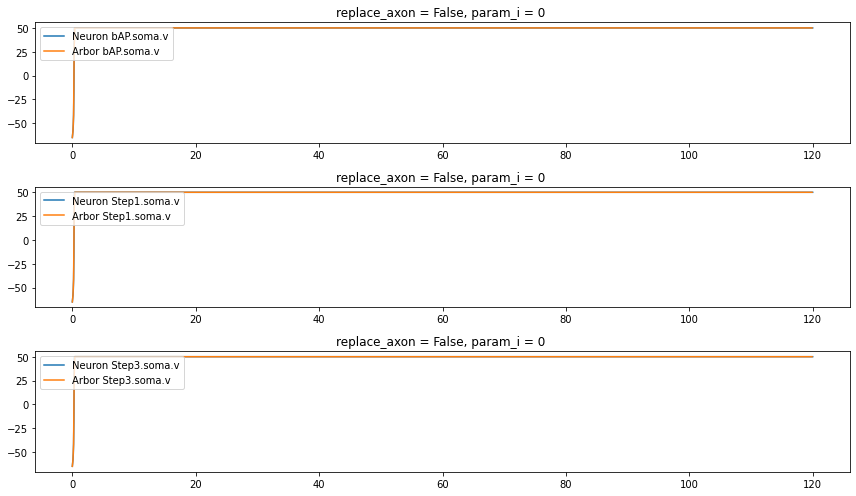

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
0,False,0,2.54,0.000417,0.0156,716,bAP.soma.v,0.000168,2.02e-08
1,False,0,2.54,0.000417,0.0156,716,Step1.soma.v,0.000169,2.21e-08
2,False,0,2.54,0.000417,0.0156,716,Step3.soma.v,0.000166,1.86e-08


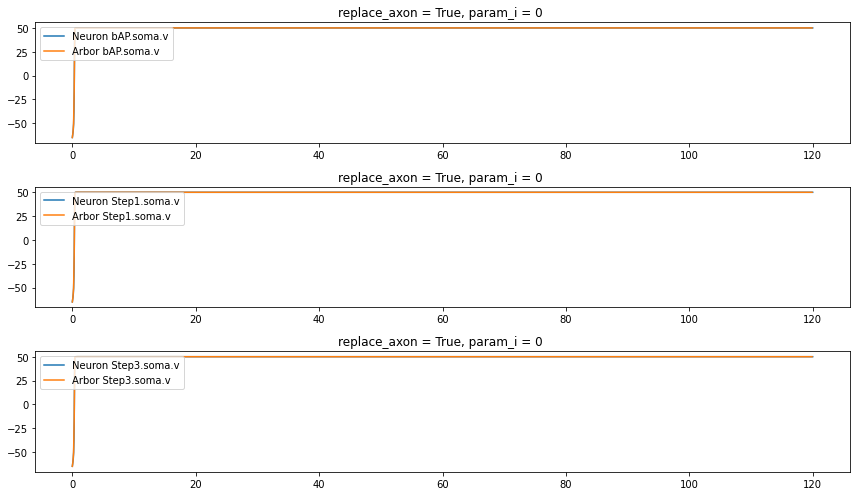

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
15,True,0,2.54,0.000417,0.0156,716,bAP.soma.v,0.000131,4.02e-08
16,True,0,2.54,0.000417,0.0156,716,Step1.soma.v,0.000128,1.47e-08
17,True,0,2.54,0.000417,0.0156,716,Step3.soma.v,0.000132,1.76e-08


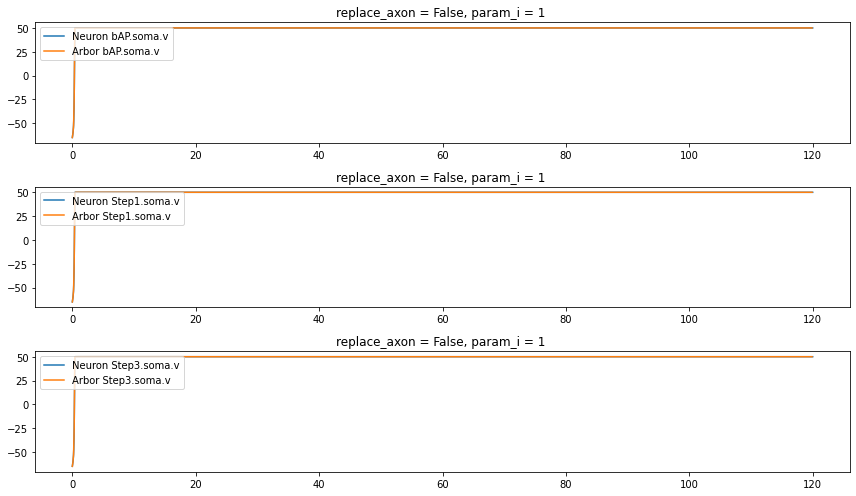

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
3,False,1,1.8,0.000737,0.0131,624,bAP.soma.v,0.000185,6.66e-09
4,False,1,1.8,0.000737,0.0131,624,Step1.soma.v,0.000186,1.51e-08
5,False,1,1.8,0.000737,0.0131,624,Step3.soma.v,0.000182,3.54e-08


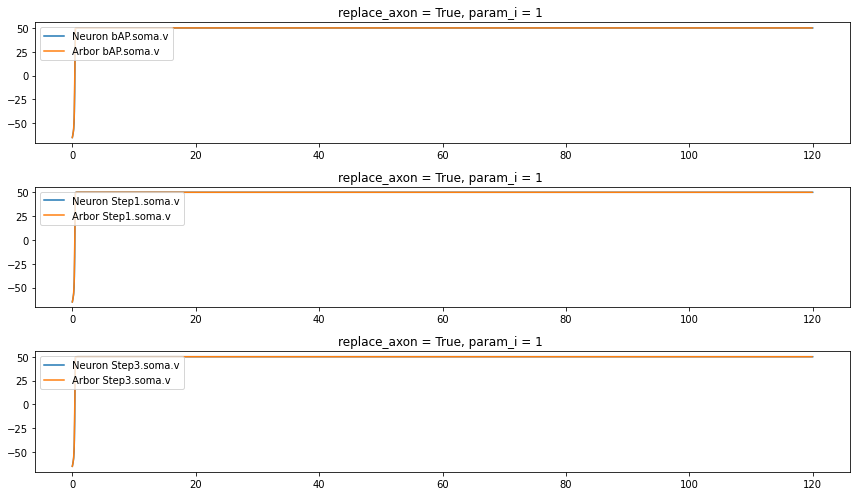

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
18,True,1,1.8,0.000737,0.0131,624,bAP.soma.v,0.000218,1.59e-08
19,True,1,1.8,0.000737,0.0131,624,Step1.soma.v,0.000218,1.4e-08
20,True,1,1.8,0.000737,0.0131,624,Step3.soma.v,0.000222,2.13e-08


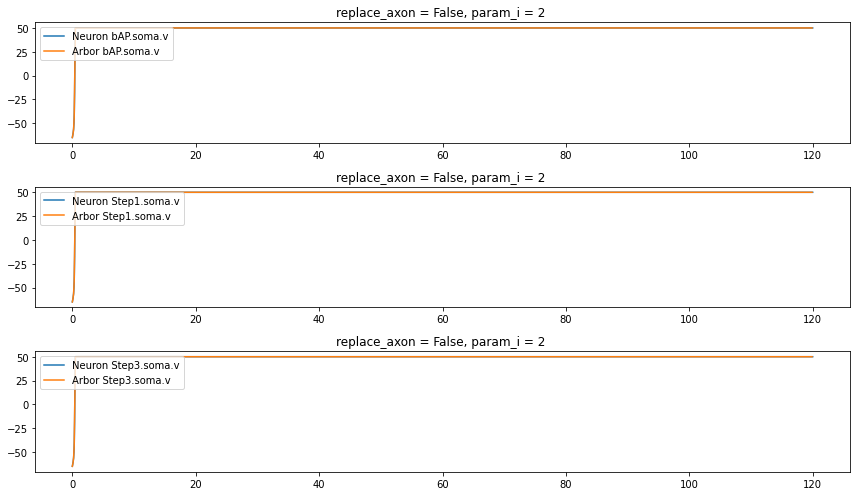

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
6,False,2,1.36,4.32e-05,0.0281,670,bAP.soma.v,0.00013,5.86e-07
7,False,2,1.36,4.32e-05,0.0281,670,Step1.soma.v,0.000128,1.97e-08
8,False,2,1.36,4.32e-05,0.0281,670,Step3.soma.v,0.000124,2.29e-08


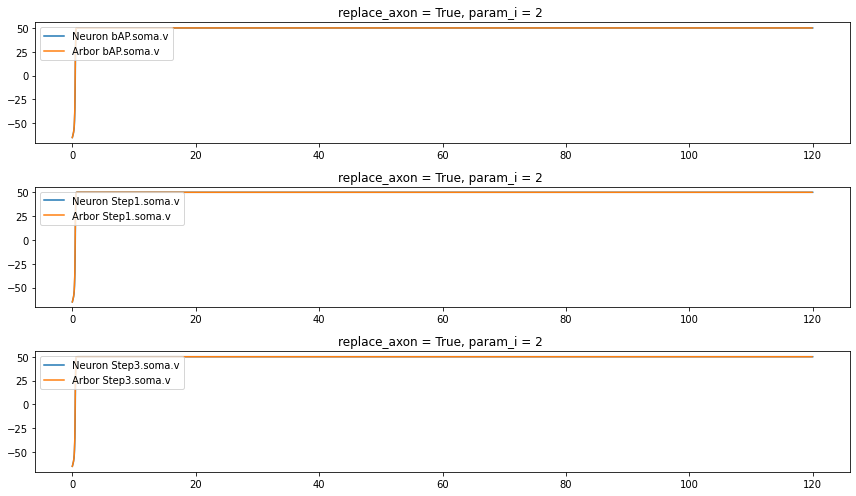

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
21,True,2,1.36,4.32e-05,0.0281,670,bAP.soma.v,0.000126,6.97e-08
22,True,2,1.36,4.32e-05,0.0281,670,Step1.soma.v,0.000132,1.91e-08
23,True,2,1.36,4.32e-05,0.0281,670,Step3.soma.v,0.000126,2.3e-08


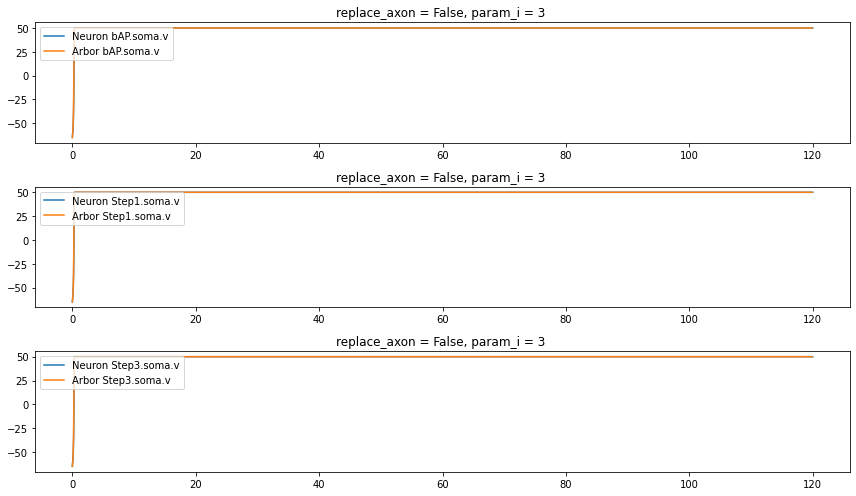

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
9,False,3,2.86,0.000315,0.00176,518,bAP.soma.v,0.000149,1.95e-08
10,False,3,2.86,0.000315,0.00176,518,Step1.soma.v,0.000158,1.71e-08
11,False,3,2.86,0.000315,0.00176,518,Step3.soma.v,0.000162,1.61e-08


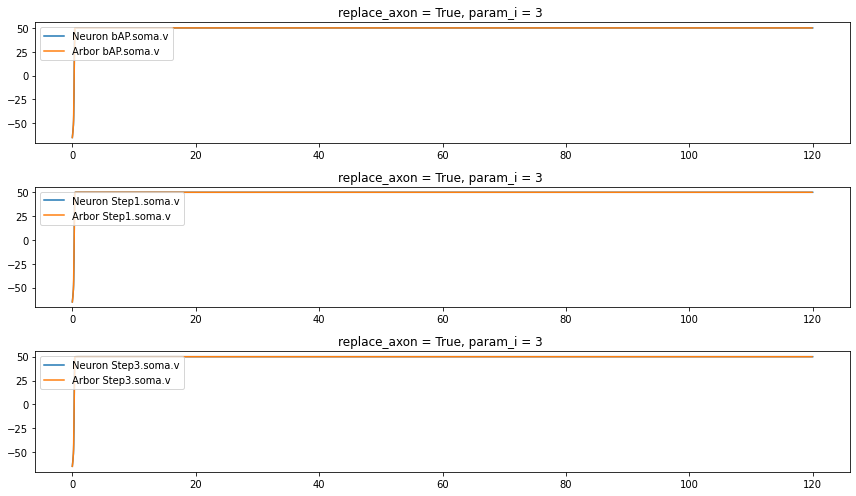

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
24,True,3,2.86,0.000315,0.00176,518,bAP.soma.v,0.000166,2.57e-08
25,True,3,2.86,0.000315,0.00176,518,Step1.soma.v,0.000168,1.43e-08
26,True,3,2.86,0.000315,0.00176,518,Step3.soma.v,0.000158,1e-08


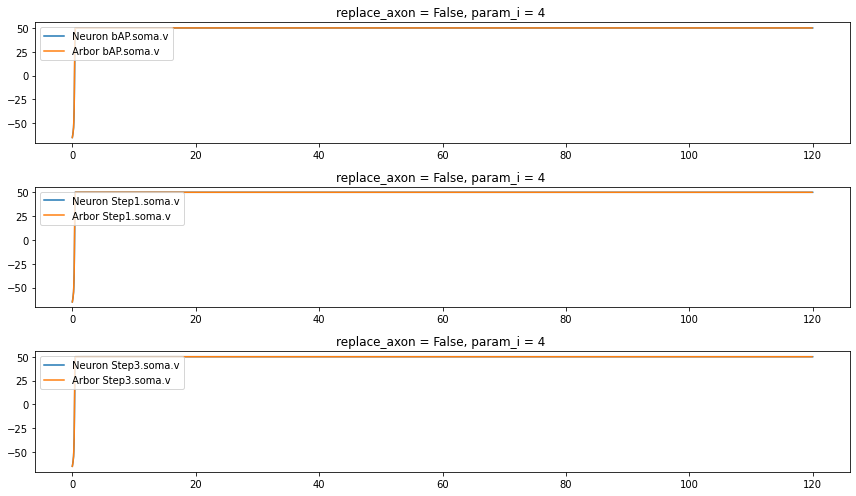

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
12,False,4,1.59,0.000782,0.00283,697,bAP.soma.v,0.000168,4.17e-08
13,False,4,1.59,0.000782,0.00283,697,Step1.soma.v,0.000166,4.69e-09
14,False,4,1.59,0.000782,0.00283,697,Step3.soma.v,0.000167,8.2e-09


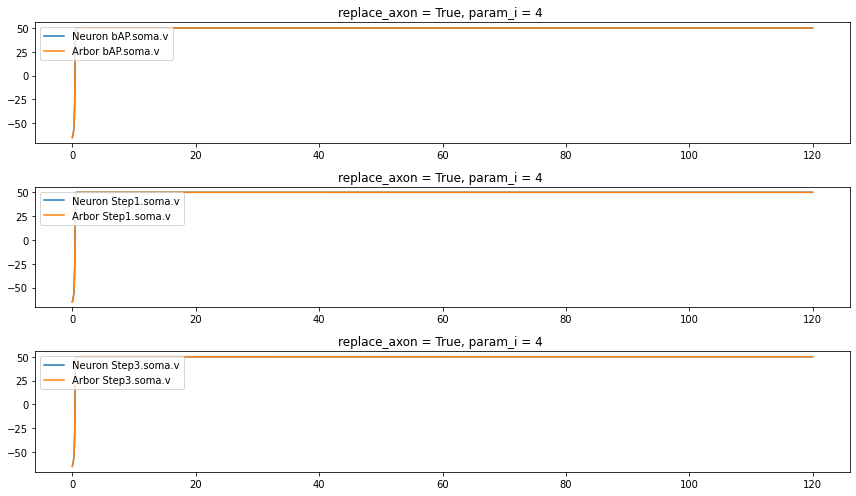

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gCa_HVAbar_Ca_HVA.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
27,True,4,1.59,0.000782,0.00283,697,bAP.soma.v,0.000173,2.84e-08
28,True,4,1.59,0.000782,0.00283,697,Step1.soma.v,0.000171,1.47e-08
29,True,4,1.59,0.000782,0.00283,697,Step3.soma.v,0.000171,1.85e-08


In [27]:
if run_fine_dt:
    for param_i in range(len(params)):
        for do_replace_axon in replace_axon:
            compare_responses(arb_responses_fine_dt,
                              nrn_responses_fine_dt,
                              l1_results_fine_dt,
                              do_replace_axon, param_i)

In [28]:
if run_spike_time_analysis and run_fine_dt:
    spike_results_fine_dt = joint_spike_analysis(arb_responses_fine_dt, nrn_responses_fine_dt, replace_axon, params)
    display(spike_results_fine_dt)

In [29]:
if run_spike_time_analysis and run_fine_dt:
    display(spike_results_fine_dt[['abs_diff Arbor to Neuron',
                                   'rel_abs_diff Arbor to Neuron [%]']].groupby('efel').describe())

The outlier in `time_to_last_spike` is gone now, both visually and quantitatively.

In [30]:
if run_spike_time_analysis and run_fine_dt:
    display(spike_results_fine_dt[ [el[spike_results_fine_dt.index.names.index('efel')] == 'time_to_last_spike'
                                    for el in spike_results_fine_dt.index] ].sort_values(
                                    by='abs_diff Arbor to Neuron', ascending=False).head(5))

In [31]:
if run_spike_time_analysis and run_fine_dt:
    display(spike_results_fine_dt[['abs_diff eFEL to Arbor-internal',
                                   'rel_abs_diff eFEL to Arbor-internal [%]']].groupby('efel').describe())

Furthermore, the mean deviation between Arbor and Neuron for eFEL spike times is significantly reduced.

In [32]:
if run_spike_time_analysis and run_fine_dt:
    display((spike_results_fine_dt[['abs_diff Arbor to Neuron']].groupby('efel').mean()/
             spike_results[['abs_diff Arbor to Neuron']].groupby('efel').mean()).rename(
                 columns={'abs_diff Arbor to Neuron': 
                         'ratio of mean abs_diff Arbor to Neuron for fine dt vs. default dt'}))
